In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os

from config import gkey




In [2]:
fire_df = pd.read_csv ('Fire.csv')
fire_df.head()

,index,ID,DATE,TIME,ZIP,BATTALION,SHIFT,COUNCIL DISTRICT,STRUCTURE TYPE,BUILDING STORIES,...,STRUCTURE LOSS,CONTENTS LOSS,TOTAL SAVED,PERCENTAGE LOSS,SPRINKLER SYSTEM,ALARM SYSTEM,ADDRESS,Lat,Lng,TOTAL LOSS
0,0,17961.0,10/29/2019,08:21 PM,75216.0,6,A,4.0,DWELLING,1.0,...,-5000.0,0.0,161370.0,3.01,NaN,NaN,1325 S MARSALIS AVE,32.732107,-96.814783,5000.0
1,1,17962.0,10/30/2019,03:42 AM,75229.0,7,A,13.0,DWELLING,1.0,...,-10000.0,0.0,525470.0,1.87,NaN,NaN,10728 LATHROP DR,32.894248,-96.857108,10000.0
2,2,17963.0,10/30/2019,10:47 AM,75241.0,5,B,3.0,DWELLING,1.0,...,-5000.0,-15000.0,286000.0,6.54,NaN,NaN,6205 S R L THORNTON SERV,32.694543,-96.824020,20000.0
3,3,17964.0,10/30/2019,05:32 PM,75243.0,2,B,10.0,DWELLING,1.0,...,-8000.0,-4000.0,114710.0,9.47,NaN,NaN,12044 WILLOWDELL DR,32.913584,-96.764435,12000.0
4,4,17965.0,10/30/2019,11:03 AM,75212.0,9,B,6.0,DWELLING,1.0,...,-45000.0,-10000.0,29000.0,65.48,NaN,NaN,2212 LAPSLEY ST,32.769986,-96.908816,55000.0


In [3]:
fire_df['TOTAL LOSS'] = fire_df['TOTAL VALUE'] - fire_df['TOTAL SAVED']
fire_df = fire_df.rename(columns={
    'SPRINKER SYSTEM':'SPRINKLER SYSTEM'
})

fire_df = fire_df.astype({'TOTAL LOSS': int})

In [4]:
# Turn unknowns into null
fire_df['ALARM SYSTEM'] = fire_df['ALARM SYSTEM'].replace({
    'UNK': None,
    'UKN': None
})

fire_df['ALARM SYSTEM'].unique()

array([nan, 'YES', 'NO'], dtype=object)

In [5]:
# Turn unkonwns into null
fire_df['SPRINKLER SYSTEM'] = fire_df['SPRINKLER SYSTEM'].replace({
    'UNK': None
})

fire_df['SPRINKLER SYSTEM'].unique()

array([nan, 'YES', 'NO'], dtype=object)

In [6]:
fire_df.to_csv('Fire.csv', index = False)

In [7]:
alarm_columns = fire_df[['TOTAL LOSS', 'PERCENTAGE LOSS', 'SPRINKLER SYSTEM', 'ALARM SYSTEM']]
alarm_columns = alarm_columns.dropna()
alarm_group = alarm_columns.groupby(['SPRINKLER SYSTEM','ALARM SYSTEM'])
alarm_describe = alarm_group.describe()
alarm_mean = alarm_group.mean()
alarm_describe

TOTAL LOSS                                \
                                   count           mean            std   
SPRINKLER SYSTEM ALARM SYSTEM                                            
NO               NO                161.0   24004.503106   49099.060662   
                 YES               181.0   31395.027624   89248.607002   
YES              NO                  3.0  184500.000000  316533.173617   
                 YES                66.0   38721.666667  186094.859627   

                                                                            \
                                  min     25%     50%       75%        max   
SPRINKLER SYSTEM ALARM SYSTEM                                                
NO               NO               0.0  1500.0  8000.0   30000.0   428000.0   
                 YES              0.0  1100.0  5500.0   22500.0   950000.0   
YES              NO            1000.0  1750.0  2500.0  276250.0   550000.0   
                 YES              0.0   300.0  1500.0   15000.0  1502000.0   

                              PERCENTAGE LOSS                              \
                                        count       mean        std   min   
SPRINKLER SYSTEM ALARM SYSTEM                                               
NO               NO                     161.0  16.567019  22.648835  0.00   
                 YES                    181.0   8.645470  15.651785  0.00   
YES              NO                       3.0  14.466667  23.707826  0.08   
                 YES                     66.0   1.632727   7.040789  0.00   

                                                           
                                 25%   50%     75%    max  
SPRINKLER SYSTEM ALARM SYSTEM                              
NO               NO            0.400  4.17  25.000  86.74  
                 YES           0.070  0.97   9.280  94.58  
YES              NO            0.785  1.49  21.660  41.83  
                 YES           0.000  0.02   0.205  48.02

In [8]:
alarm_columns['SYSTEM INSTALLED'] = ' '


In [9]:
# Fill 'SYSTEM INSTALLED' column with correct data

alarm_columns['SYSTEM INSTALLED'].loc[
    (alarm_columns['SPRINKLER SYSTEM'] == 'NO') &
    (alarm_columns['ALARM SYSTEM'] == 'NO')
] = 'Neither'

alarm_columns['SYSTEM INSTALLED'].loc[
    (alarm_columns['SPRINKLER SYSTEM'] == 'NO') &
    (alarm_columns['ALARM SYSTEM'] == 'YES')
] = 'Alarm Only'

alarm_columns['SYSTEM INSTALLED'].loc[
    (alarm_columns['SPRINKLER SYSTEM'] == 'YES') &
    (alarm_columns['ALARM SYSTEM'] == 'NO')
] = 'Sprinkler Only'

alarm_columns['SYSTEM INSTALLED'].loc[
    (alarm_columns['SPRINKLER SYSTEM'] == 'YES') &
    (alarm_columns['ALARM SYSTEM'] == 'YES')
] = 'Both'

alarm_columns

C:\Users\Rob\anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,TOTAL LOSS,PERCENTAGE LOSS,SPRINKLER SYSTEM,ALARM SYSTEM,SYSTEM INSTALLED
11,20000,0.92,YES,YES,Both
13,1100,0.01,YES,YES,Both
15,1100,0.02,NO,YES,Alarm Only
16,1000,1.00,NO,NO,Neither
17,45000,58.10,NO,NO,Neither
...,...,...,...,...,...
613,1250,0.04,NO,YES,Alarm Only
615,0,0.00,YES,YES,Both
616,17500,6.70,NO,YES,Alarm Only
619,600,40.00,NO,NO,Neither


In [18]:
# Prepare dictionary for box plot (Percentage Loss)
system_list = alarm_columns['SYSTEM INSTALLED'].unique()
system_dict = {}
for system in system_list:
    temp_list = alarm_columns['PERCENTAGE LOSS'].loc[alarm_columns['SYSTEM INSTALLED'] == system]
    system_dict[system] = temp_list


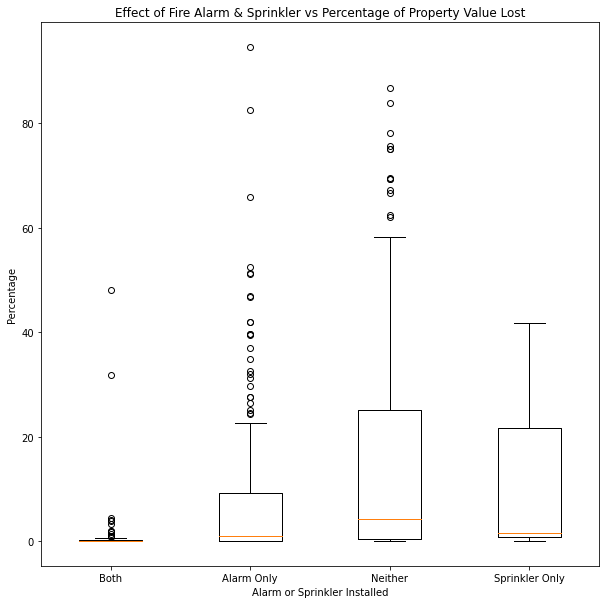

In [27]:
labels, data = [*zip(*system_dict.items())]
plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.xlabel("Alarm or Sprinkler Installed")
plt.ylabel("Percentage")
plt.title("Effect of Fire Alarm & Sprinkler vs Percentage of Property Value Lost")
plt.rcParams["figure.figsize"] = (6,6)
plt.show()

In [28]:
# Prepare dictionary for box plot (Total Loss)
system_list = alarm_columns['SYSTEM INSTALLED'].unique()
system_dict = {}
for system in system_list:
    temp_list = alarm_columns['TOTAL LOSS'].loc[alarm_columns['SYSTEM INSTALLED'] == system]
    system_dict[system] = temp_list

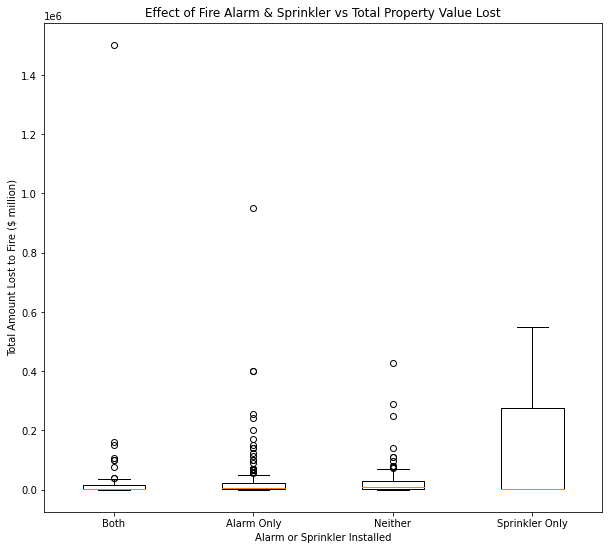

In [38]:
labels, data = [*zip(*system_dict.items())]
plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.xlabel("Alarm or Sprinkler Installed")
plt.ylabel("Total Amount Lost to Fire ($ million)")
plt.title("Effect of Fire Alarm & Sprinkler vs Total Property Value Lost")
plt.rcParams["figure.figsize"] = (10,20)

plt.show()